In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import decoupler as dc
import sys
sys.path.append('/home/efarr/Documents/GitHub/metalinks/Tests/Figures')
from aux import *
from scipy.stats import fisher_exact
import statsmodels.stats.multitest as multi
from pypath.utils import mapping


In [127]:
# # Load interactions
# df = cosmos_DE_before('/home/efarr/Documents/BC/TestDBs/Kidney_after_DB_F_kidneyonly.csv')
# df['MetName'] = df['MetName'].str.replace('"', '')
# df['LR'] = df['MetName'] + '_' + res_df_cut['symbol']
# df = df.sort_values(by='metalinks', ascending=False, key = lambda x: np.abs(x))
# df.drop_duplicates(subset='LR', inplace=True)

In [161]:
# load interactions
df = pd.read_csv('/home/efarr/Documents/BC/TestDBs/Kidney_after_DB_F_kidneyonly.csv')
df['MetName'] = df['MetName'].str.replace('"', '')
df['HMDB'] = df['HMDB'].str.replace('"', '')
df['Symbol'] = df['Symbol'].str.replace('"', '')
df['LR'] = df['MetName'] + '_' + df['Symbol']
df['DB'] = df['DB'].str.replace('"', '')
df.drop_duplicates(subset='LR', inplace=True)

In [162]:
# load additional metabolite pathways
mapping = pd.read_excel('/home/efarr/Documents/GitHub/metalinks_benchmark/scripts/MetabolomicsData_Hakimi/Input_MetabolomicsResults/Supplementarytable2_mmc2.xlsx', sheet_name='S2', skiprows=4)
mapping.dropna(subset=['HMDB'], inplace=True)
# add '00' after the first 4 characters
mapping['HMDB'] = mapping['HMDB'].astype(str)
mapping['HMDB'] = mapping['HMDB'].apply(lambda x: x[:4] + '00' + x[4:] if len(x) > 4 else x)
mapping.index = mapping['HMDB']
mapping.rename(columns={'Unnamed: 9': 'Pathway_sorted'}, inplace=True)
mapping = mapping[['Pathway_sorted']]

# add to df
df = df.join(mapping, on='HMDB', how='left', lsuffix='_df', rsuffix='_additional')

In [163]:
# Load statisic from COSMOS
RNA = pd.read_csv('/home/efarr/Documents/metalinks/Data/Intermediate/COSMOS/RNA_ttop_tumorvshealthy.csv', index_col=0)
RNA_IDS = pd.read_csv('/home/efarr/Documents/metalinks/Data/Intermediate/Mapping/COSMOS_RNA.csv', index_col=1)
RNA = RNA.join(RNA_IDS, how='left')
RNA.rename(columns={'SYMBOL': 'Symbol'}, inplace=True)
RNA.index = RNA['Symbol']
RNA = RNA.iloc[:,0:6]


MET = pd.read_csv('/home/efarr/Documents/metalinks/Data/Intermediate/COSMOS/metab_ttop_tumour_vs_healthy.csv', index_col=0)
COSMOS_mapping = pd.read_csv('/home/efarr/Documents/metalinks/Data/Intermediate/Mapping/ocean_mets.csv', index_col=0)
metabolites = MET.join(COSMOS_mapping, how='left')
metabolites.index = metabolites['HMDB']
MET = metabolites.iloc[:,0:6]

In [251]:
res_df = df.join(MET, on='HMDB', how='inner')
res_df = res_df.join(RNA, on='Symbol', how='inner', lsuffix='_met', rsuffix='_rna')
res_df['metalinks'] = (res_df['t_met'] + res_df['t_rna']) / 2
res_df.sort_values(by='metalinks', ascending=False, key = lambda x: np.abs(x), inplace=True)

In [252]:
# remove rows that dont have a a.database or a.experimental value over 500, a.prediction over 700 or a.combined over 900 or res_df['DB'] != "StitchMetaboliteReceptor"
res_df_cut = res_df[(res_df['a.database'] > 500) | (res_df['a.experiment'] > 500) | (res_df['a.prediction'] > 700) | (res_df['DB'] != "StitchMetaboliteReceptor")]

In [253]:
# Function to clean the data in the columns
def clean_column(column):
    if isinstance(column, list):
        cleaned_values = [value.replace('"', '') for value in column]
        cleaned_values = [value.replace(']', '') for value in column]
        cleaned_values = [value.replace('[', '') for value in column]
    else:
        cleaned_values = [str(column).replace('"', '')]
        cleaned_values = [str(column).replace(']', '')]
        cleaned_values = [str(column).replace('[', '')]
    return cleaned_values

# Split and clean the 'Pathways' and 'Diseases' columns in the DataFrame
res_df_cut['Pathways_metabolite'] = res_df_cut['m.pathways'].str.split(',').apply(clean_column)
res_df_cut['Diseases_metabolite'] = res_df_cut['m.diseases'].str.split(',').apply(clean_column)

/tmp/ipykernel_45799/1117151697.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_cut['Pathways_metabolite'] = res_df_cut['m.pathways'].str.split(',').apply(clean_column)
/tmp/ipykernel_45799/1117151697.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_cut['Diseases_metabolite'] = res_df_cut['m.diseases'].str.split(',').apply(clean_column)


In [255]:
res_df_cut['Pathways_metabolite'] = res_df_cut['m.pathways'].str.split('"')
# remove elements from nchar that are less that 4 characters long
res_df_cut['Pathways_metabolite'] = res_df_cut['Pathways_metabolite'].apply(lambda x: [i for i in x if len(i) > 4])


/tmp/ipykernel_45799/2500007421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_cut['Pathways_metabolite'] = res_df_cut['m.pathways'].str.split('"')
/tmp/ipykernel_45799/2500007421.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_cut['Pathways_metabolite'] = res_df_cut['Pathways_metabolite'].apply(lambda x: [i for i in x if len(i) > 4])


In [266]:
# load  pathways from .gmt found in  /home/efarr/Documents/metalinks/Data/Source/Other_DBs/c2.all.v2023.1.Hs.symbols.gmt
with open('/home/efarr/Documents/metalinks/Data/Source/Other_DBs/c2.cp.kegg.v2023.1.Hs.symbols.gmt') as f:
    pathways = [line.strip().split('\t') for line in f.readlines()]

# Create a dictionary of pathways and genes
pathway_dict = {}
for pathway in pathways:
    pathway_dict[pathway[0]] = pathway[2:]

# create dictionary of which pathways belog to which gene
gene_dict = {}
for pathway in pathways:
    for gene in pathway[2:]:
        if gene in gene_dict:
            gene_dict[gene].append(pathway[0])
        else:
            gene_dict[gene] = [pathway[0]]

# add the pathways list to the respective gene symbol in df using the gene_dict
res_df_cut['Pathways_gene'] = res_df_cut['Symbol'].map(gene_dict)

# lower both df['Pathways'] and df['Pathways_gene'] to make the comparison easier
res_df_cut['Pathways_metabolite'] = res_df_cut['Pathways_metabolite'].apply(lambda x: [i.lower() for i in x])
#res_df_cut['Pathways_gene'] = res_df_cut['Pathways_gene'].apply(lambda x: [i.lower() for i in x ])

# remove '_' from the pathways in df['Pathways_gene']
# res_df_cut['Pathways_gene'] =res_df_cut['Pathways_gene'].apply(lambda x: [i.replace('_', ' ') for i in x])




/tmp/ipykernel_45799/167846180.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_cut['Pathways_gene'] = res_df_cut['Symbol'].map(gene_dict)
/tmp/ipykernel_45799/167846180.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df_cut['Pathways_metabolite'] = res_df_cut['Pathways_metabolite'].apply(lambda x: [i.lower() for i in x])


In [267]:
res_df_cut.columns

Index(['HMDB', 'MetName', 'Symbol', 'Receptor', 'DB', 'CellLoc', 'BSLoc',
       'TissueLoc', 'm.pathways', 'm.diseases', 'Mode', 'comb', 'a.database',
       'a.experiment', 'a.textmining', 'a.prediction', 'LR', 'Pathway_sorted',
       'Diseases_metabolite', 'Pathways_metabolite', 'logFC_met',
       'AveExpr_met', 't_met', 'P.Value_met', 'adj.P.Val_met', 'B_met',
       'logFC_rna', 'AveExpr_rna', 't_rna', 'P.Value_rna', 'adj.P.Val_rna',
       'B_rna', 'metalinks', 'Pathways_gene'],
      dtype='object')

In [271]:
# create dataframe that explodes the 'Pathways' column mapping to he HMDB column
test = res_df_cut[['Pathway_sorted', 'Pathways_gene', 'LR']].explode('Pathways_gene')
#test = test.explode('Pathways_gene')
test.drop_duplicates(inplace=True)
# remove everythin up to the first ' ' in the pathways_gene column
#test['Pathways_gene'] = test['Pathways_gene'].apply(lambda x: x.split(' ', 1)[1])
A = test[['Pathway_sorted', 'LR']]
A.columns = ['source', 'target']
B = test[['Pathways_gene', 'LR']]
B.columns = ['source', 'target']
net = pd.concat([A,B], axis=0)
net.drop_duplicates(inplace=True)
net['weight'] = 1
mat = res_df_cut['metalinks']
mat.index = res_df_cut['LR']
mat = pd.DataFrame(mat).T
res = dc.run_ulm(mat=mat, net=net, min_n = 5)
res_df = pd.concat([res[0], res[1]], axis=0).T
res_df.columns = [ 'Enrichment Score', 'p-value']
res_df.sort_values(by='p-value', inplace=True)


In [274]:
# lower all indices of res_df and replace KEGG_ by ''
res_df.index = res_df.index.str.lower()
res_df.index = res_df.index.str.replace('kegg_', '')
# replae _ by ' ' in the index
res_df.index = res_df.index.str.replace('_', ' ')
# remove the row were the index is 'nan
res_df = res_df[res_df.index != 'nan']
res_df

,Enrichment Score,p-value
aldosterone regulated sodium reabsorption,-4.451300,0.000012
toll like receptor signaling pathway,3.849886,0.000144
leishmania infection,3.395062,0.000779
glycerolipid metabolism,-3.096950,0.002140
natural killer cell mediated cytotoxicity,2.851937,0.004647
focal adhesion,2.681321,0.007739
cytokine cytokine receptor interaction,2.515931,0.012394
leukocyte transendothelial migration,2.290042,0.022713
chemokine signaling pathway,2.281633,0.023211
intestinal immune network for iga production,2.126742,0.034257


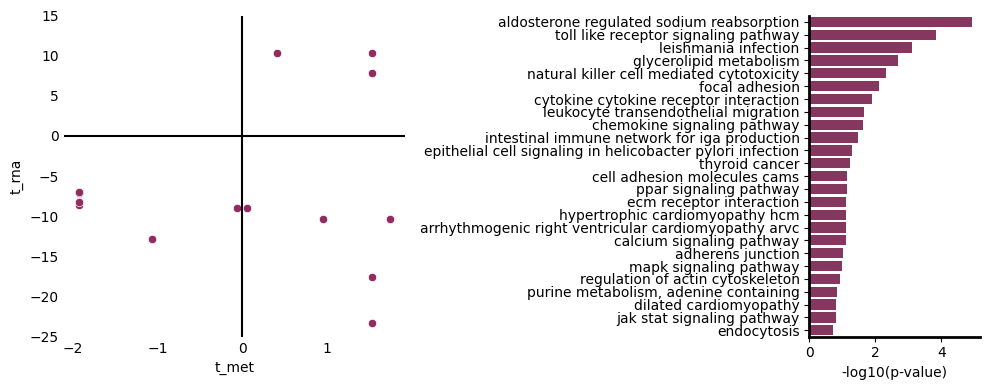

In [275]:
from adjustText import adjust_text
# Assuming your DataFrame is called 'df' with columns 'LR', 't_metabolites', 't_RNA', and 'metalinks'

test = res_df_cut[['LR', 't_met', 't_rna', 'metalinks']].head(15)
# plot two plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
# ax3 = plt.subplot(gs[1])

# Create a scatterplot using seaborn
sns.scatterplot(data=test, x='t_met', y='t_rna', color='#932A61', ax=ax1)

# # Add labels to the data points
# texts = []
# for i in range(len(test)):
#     texts.append(ax1.text(test['t_metabolites'].iloc[i], test['t_RNA'].iloc[i], test['LR'].iloc[i]))

# Remove spines (surrounding square)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set ticks on the crosses
ax1.tick_params(axis='both', which='both', length=0)

# Display x and y-axis crosses at zero line
ax1.axhline(0, color='black', linestyle='-')
ax1.axvline(0, color='black', linestyle='-')

ax1.set_ylim(-25, 15)

# Set x and y-axis labels
ax1.set_xlabel('t_met')
ax1.set_ylabel('t_rna')

# Add margins between labels and plot edges
#margin = 0.1  # Adjust the margin as per your preference
# x_min, x_max = ax1.set_xlim()
# ax1.set_xlim(x_min - margin, x_max + margin)

# Adjust label positions to avoid overlap
#adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))


# SECOND plot
significants = res_df.head(25)

# Invert the p-values
inverted_pvalues = -np.log10(significants['p-value'])

sns.barplot(data=significants, x=inverted_pvalues, y=significants.index, color='#932A61', ax=ax2)

ax2.set_yticks(range(len(significants)), significants.index)
ax2.set_xlabel('-log10(p-value)')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_linewidth(2)
ax2.spines['bottom'].set_linewidth(2)
plt.tight_layout()
plt.show()


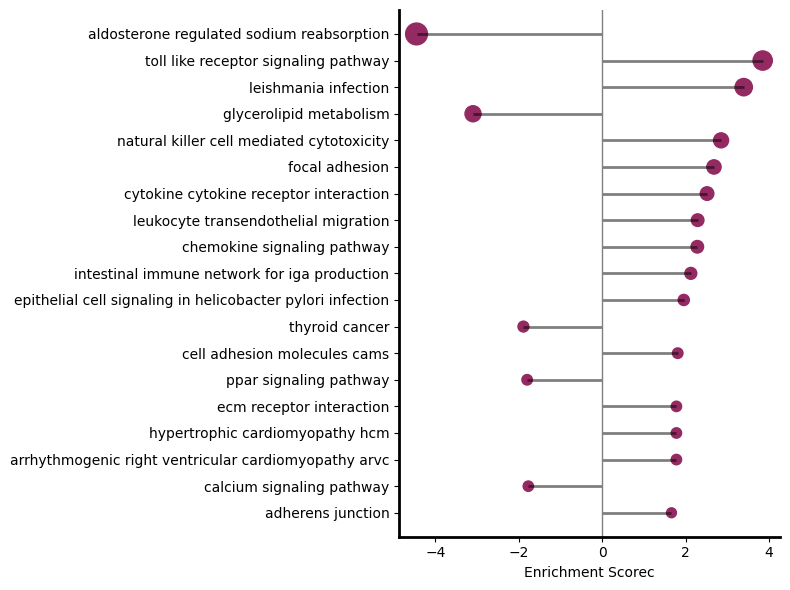

In [310]:
# Assuming you have a DataFrame called 'data' with columns 'LR', 'ttest', and 'pvalue'
data = res_df[['Enrichment Score','p-value']]
data['Pathway'] = data.index

data = data[data['p-value'] < 0.1]
#invert the row order
data = data.iloc[::-1]

# Set the plot size and create subplots
plt.figure(figsize=(8, 6))
ax = plt.subplot()

# Plot the lollipops
col1 = '#932A61'
col2 = 'black'

inverted_pvalues = -np.log10(data['p-value'])

ax.scatter(data['Enrichment Score'], data['Pathway'], color=col1, alpha=1, s=inverted_pvalues*50)
ax.hlines(y=data['Pathway'], xmin=0, xmax=data['Enrichment Score'], color=col2, alpha=0.5, linewidth=2)

# Customize the plot
ax.set_xlabel('Enrichment Scorec')
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1)
ax.grid(True, axis='y', linestyle='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Show the plot
plt.tight_layout()
plt.show()

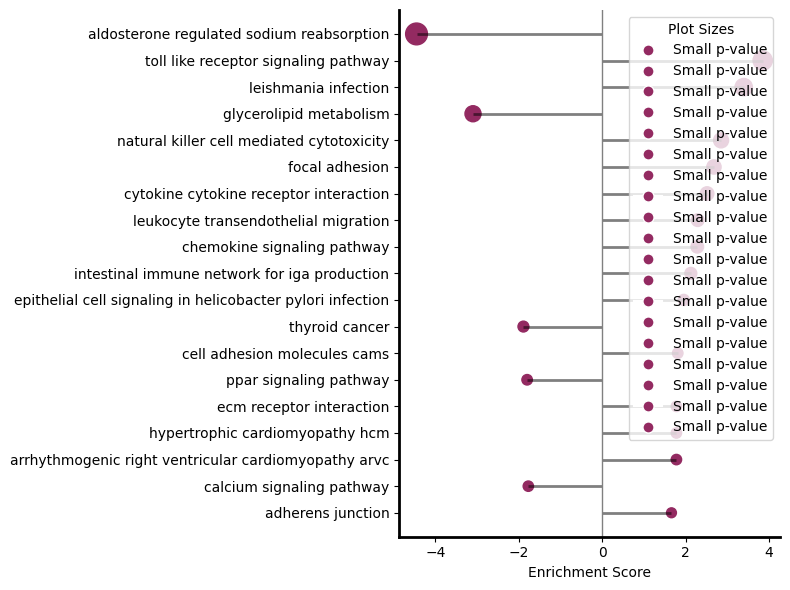

In [312]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# Assuming you have a DataFrame called 'data' with columns 'Enrichment Score' and 'p-value'
data = res_df[['Enrichment Score', 'p-value']]
data['Pathway'] = data.index

data = data[data['p-value'] < 0.1]
# invert the row order
data = data.iloc[::-1]

# Set the plot size and create subplots
plt.figure(figsize=(8, 6))
ax = plt.subplot()

# Plot the lollipops
col1 = '#932A61'
col2 = 'black'

inverted_pvalues = -np.log10(data['p-value'])
plot_sizes = inverted_pvalues * 50

# Create custom legend labels and handles for different plot sizes
legend_labels = ['Small p-value', 'Medium p-value', 'Large p-value']
legend_handles = []

# Define thresholds for different plot size categories
small_threshold = 10
medium_threshold = 20

# Iterate through the data and assign plot sizes to categories
for i in range(len(data)):
    if inverted_pvalues.iloc[i] <= small_threshold:
        legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col1, markersize=8, label=legend_labels[0]))
    elif small_threshold < inverted_pvalues.iloc[i] <= medium_threshold:
        legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col1, markersize=12, label=legend_labels[1]))
    else:
        legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=col1, markersize=16, label=legend_labels[2]))

# Scatter plot with legend handles
sc = ax.scatter(data['Enrichment Score'], data['Pathway'], color=col1, alpha=1, s=plot_sizes)

ax.hlines(y=data['Pathway'], xmin=0, xmax=data['Enrichment Score'], color=col2, alpha=0.5, linewidth=2)

# Customize the plot
ax.set_xlabel('Enrichment Score')
ax.axvline(x=0, color='gray', linestyle='-', linewidth=1)
ax.grid(True, axis='y', linestyle='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# Add a custom legend
plt.legend(handles=legend_handles, title='Plot Sizes', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()



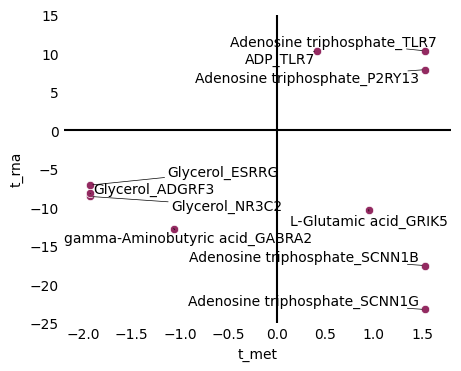

In [291]:
from adjustText import adjust_text
# Assuming your DataFrame is called 'df' with columns 'LR', 't_metabolites', 't_RNA', and 'metalinks'

test = res_df_cut[['LR', 't_met', 't_rna', 'metalinks']].head(10)
# plot two plot side by side
fig, (ax1) = plt.subplots(1, 2, figsize=(5, 4))

gs = gridspec.GridSpec(1, 1, width_ratios=[1])

ax1 = plt.subplot(gs[0])
# ax3 = plt.subplot(gs[1])

# Create a scatterplot using seaborn
sns.scatterplot(data=test, x='t_met', y='t_rna', color='#932A61', ax=ax1)

# # Add labels to the data points
texts = []
for i in range(len(test)):
    texts.append(ax1.text(test['t_met'].iloc[i], test['t_rna'].iloc[i], test['LR'].iloc[i]))

# Remove spines (surrounding square)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)

# Set ticks on the crosses
ax1.tick_params(axis='both', which='both', length=0)

# Display x and y-axis crosses at zero line
ax1.axhline(0, color='black', linestyle='-')
ax1.axvline(0, color='black', linestyle='-')

ax1.set_ylim(-25, 15)

# Set x and y-axis labels
ax1.set_xlabel('t_met')
ax1.set_ylabel('t_rna')

# Add margins between labels and plot edges
margin = 0.1  # Adjust the margin as per your preference
x_min, x_max = ax1.set_xlim()
ax1.set_xlim(x_min - margin, x_max + margin)

# Adjust label positions to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))


plt.show()


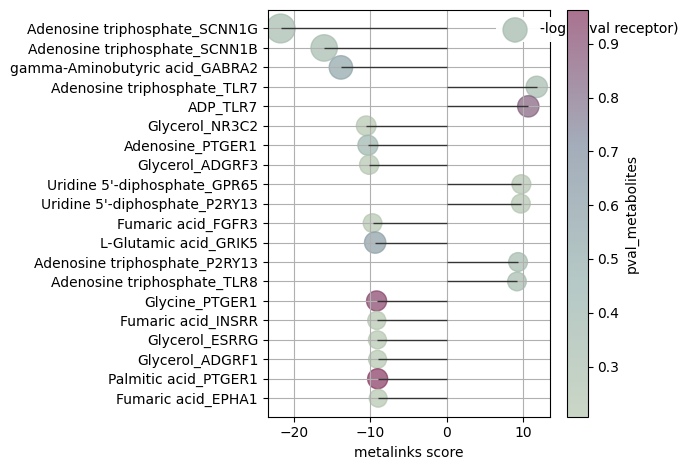

In [5]:

# Assuming you have a DataFrame called 'data' with columns 'LR', 'ttest', and 'pvalue'
data = df[['LR', 'metalinks', 'adj.P.Val_metabolites', 'adj.P.Val_RNA']].sort_values(by='metalinks', ascending=False, key=lambda x: np.abs(x)).head(20)

# Set up the figure and axis
fig, ax = plt.subplots()

# Calculate the reciprocal of 'adj.P.Val_metabolites' and use it to set the size of the dots
sizes = -np.log2(data['adj.P.Val_RNA'])

# Plot the lollipops

colors = ['#B2C9AB', '#92B6B1', '#788AA3', '#932A61']
color_list = ['#B2C9AB', '#92B6B1', '#788AA3', '#932A61']
color_list_r = ['#932A61','#788AA3', '#92B6B1', '#B2C9AB']
adjusted_colors = [sns.desaturate(c, 0.75) for c in color_list]
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', adjusted_colors)


colormap = 'coolwarm'
colormap = cmap_custom

ax.hlines(y=range(len(data)), xmin=0, xmax=data['metalinks'], color='black', alpha=0.7, linewidth=1)
scatter = ax.scatter(x=data['metalinks'], y=range(len(data)), c=data['adj.P.Val_metabolites'], s=sizes*10, cmap=colormap, alpha=0.7, label='-log2(pval receptor)')

# Customize the plot
ax.set_xlabel('metalinks score')
ax.grid(True)

# Inverse the y-axis
ax.invert_yaxis()

# Set the y-tick labels to the interaction labels
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data['LR'])

# Add a colorbar using the scatter plot as the mappable
cbar = plt.colorbar(scatter)
cbar.set_label('pval_metabolites')

# Add a legend
legend_sizes = [10, 20, 30]  # Adjust the sizes as needed
legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
    # remove box around the legend
ax.get_legend().get_frame().set_linewidth(0.0)

# Position the legend on top of the colorbar
cbar_position = cbar.ax.get_position()
ax.add_artist(legend)
legend.set_bbox_to_anchor((cbar_position.x0, cbar_position.y1 + 0.02, cbar_position.width, 0.1))

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


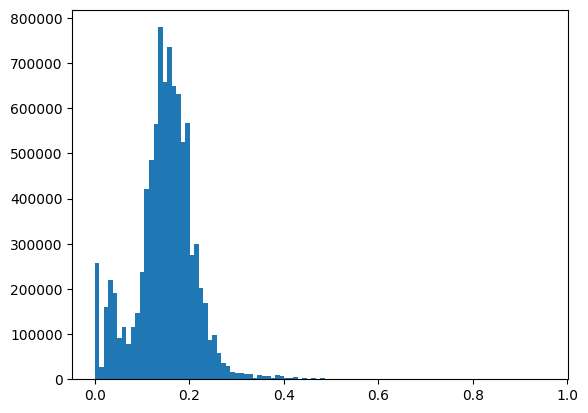

In [28]:
from fastDamerauLevenshtein import damerauLevenshtein
test['DL'] = test.apply(lambda x: damerauLevenshtein(x['Pathways_metabolite'], x['Pathways_gene']), axis=1)
plt.hist(test['DL'], bins=100)
plt.show()

In [43]:
# check overlap between pathways in the metabolite and gene columns
test[test['DL'] > 0.8]

,Pathways_metabolite,Pathways_gene,LR,DL
160,glycolysis / gluconeogenesis,glycolysis and gluconeogenesis,Adenosine triphosphate_SLC2A1,0.866667
1728,purine metabolism,purine metabolism,Adenosine triphosphate_GUCY1B1,0.944444
4123,purine metabolism,purine metabolism,Adenosine triphosphate_GUCY1A1,0.944444
1646,purine metabolism,purine metabolism,Adenosine triphosphate_GUCY1A2,0.944444
1332,fatty acid metabolism,fatty acid metabolism,Palmitic acid_RXRA,0.954545
2215,purine metabolism,purine metabolism,Adenosine triphosphate_NPR1,0.944444
3445,purine metabolism,purine metabolism,Adenosine triphosphate_GUCY2C,0.944444
3870,purine metabolism,purine metabolism,Adenosine triphosphate_NPR2,0.944444


In [22]:
df['Pathways_gene'].value_counts().head(20)

[kim mycn amplification targets up, buckanovich t lymphocyte homing on tumor dn, lee sp4 thymocyte, meissner brain hcp with h3k4me3 and h3k27me3, chandran metastasis dn, eppert progenitor, changolkar h2afy targets dn, liu ovarian cancer tumors and xenografts xdgs dn, reactome hemostasis, reactome signaling by gpcr, reactome class a 1 rhodopsin like receptors, reactome signal amplification, reactome g alpha q signalling events, reactome p2y receptors, reactome nucleotide like purinergic receptors, reactome adp signalling through p2y purinoceptor 1, reactome gpcr ligand binding, reactome platelet activation signaling and aggregation, wp nucleotide gpcrs, wp purinergic signaling, wp gpcrs class a rhodopsinlike, lee recent thymic emigrant, zhou inflammatory response fima up, dodd nasopharyngeal carcinoma up, kegg neuroactive ligand receptor interaction]                                                                                                                                           

In [85]:
test = df[['Diseases', 'LR']].explode('Diseases')
test.drop_duplicates(inplace=True)
net = test#[['LR', 'Pathways']]
net.columns = ['source', 'target']
net['weight'] = 1
mat = df['metalinks']
mat.index = df['LR']
mat = pd.DataFrame(mat).T
res = dc.run_ulm(mat=mat, net=net, min_n = 5)
res_df = pd.concat([res[0], res[1]], axis=0).T
res_df.columns = [ 'Enrichment Score', 'p-value']
res_df.sort_values(by='p-value', inplace=True)
res_df.head(20)


,Enrichment Score,p-value
Rachialgia,5.915037,5.552712e-09
Subarachnoid hemorrhage,5.915037,5.552712e-09
Stroke,5.915037,5.552712e-09
Neuroinfection,5.915037,5.552712e-09
Colorectal cancer,-5.337079,1.337433e-07
Irritable bowel syndrome,-5.114108,4.236506e-07
Epilepsy,4.846211,1.601249e-06
Rheumatoid arthritis,-4.109286,4.516073e-05
Colorectal cancer,-4.034385,6.175907e-05
Lung Cancer,-3.916786,9.996072e-05


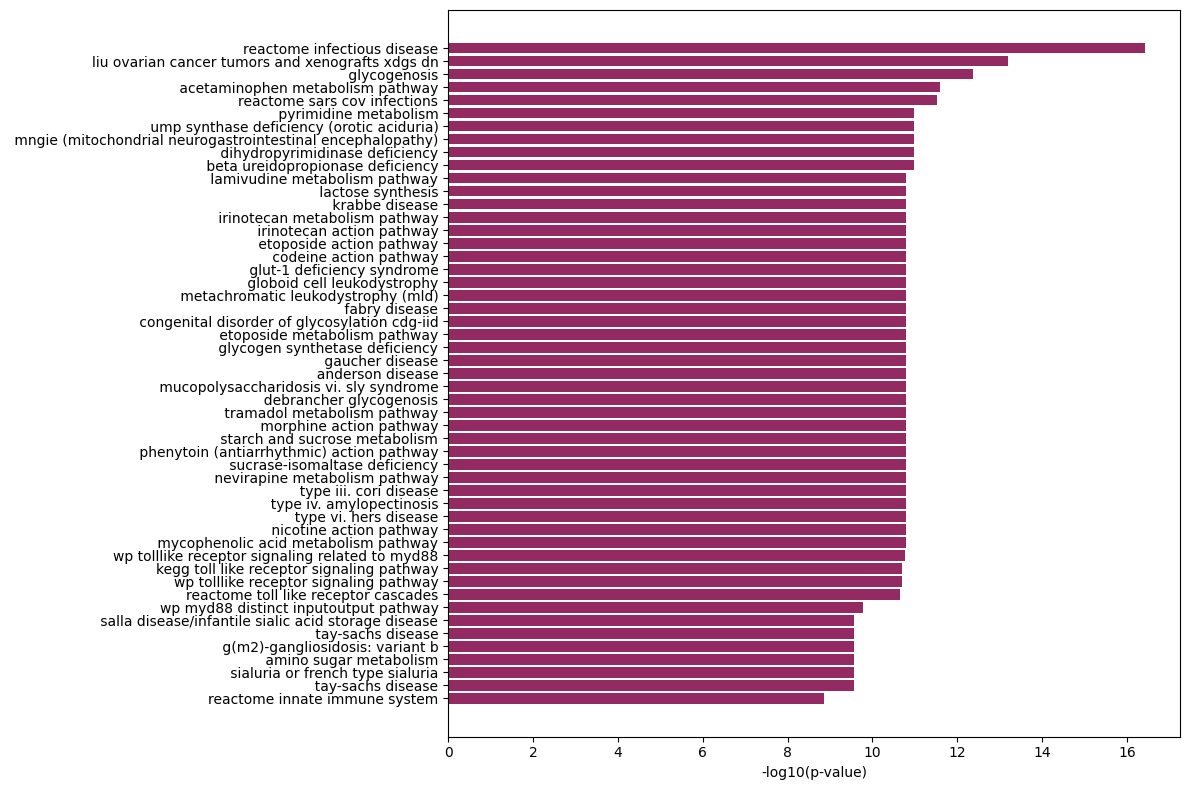

In [13]:
import matplotlib.pyplot as plt

significants = res_df[res_df['p-value'] < 0.000000005]

# Invert the p-values
inverted_pvalues = -np.log10(significants['p-value'])



# Create a bar plot
plt.figure(figsize=(12, 8))
plt.barh(range(len(significants)), inverted_pvalues, color='#932A61')
plt.yticks(range(len(significants)), significants.index)
# invert the y axis
plt.gca().invert_yaxis()
plt.xlabel('-log10(p-value)')
plt.tight_layout()
plt.show()


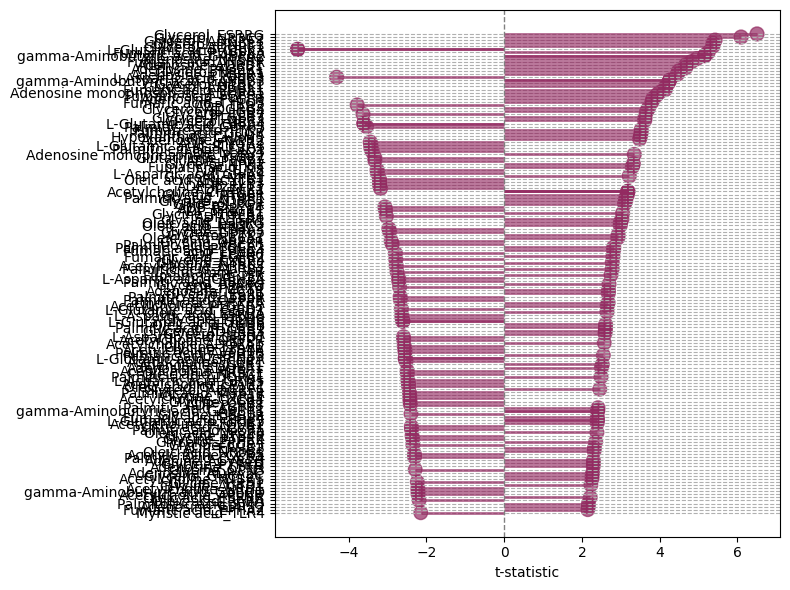

In [19]:
# Assuming you have a DataFrame called 'data' with columns 'LR', 'ttest', and 'pvalue'
data = res[['LR', 'ttest', 'pvalue']]

data = data[data['pvalue'] < 0.05]

# Sort the DataFrame by absolute t-statistic in descending order
data_sorted = data.assign(abs_tstatistic=data['ttest'].abs()).sort_values(by='abs_tstatistic', ascending=True)

# Set the plot size and create subplots
plt.figure(figsize=(8, 6))
ax = plt.subplot()

# Plot the lollipops
col = '#932A61'
ax.hlines(y=data_sorted['LR'], xmin=0, xmax=data_sorted['ttest'], color=col, alpha=0.7, linewidth=2)
ax.scatter(data_sorted['ttest'], data_sorted['LR'], color=col, alpha=0.7, s=100 * (1 - data_sorted['pvalue']))

# Customize the plot
ax.set_xlabel('t-statistic')
ax.axvline(x=0, color='gray', linestyle='--', linewidth=1)
ax.grid(True, axis='y', linestyle='--')

# Show the plot
plt.tight_layout()
plt.show()



In [ ]:
data

,ID,t_statistic,p_value
0,A,1.5,0.020
1,B,-2.1,0.001
2,C,0.8,0.050
3,D,-1.3,0.010


In [ ]:
genes = res[res['pvalue'] < 0.05]['hmdb_id']
metabolites = res[res['pvalue'] < 0.05]['symbol']

In [3]:
RNA = pd.read_csv('/home/efarr/Documents/metalinks/Data/Intermediate/COSMOS/RNA_ttop_tumorvshealthy.csv', index_col=0)

In [4]:
RNA

,logFC,AveExpr,t,P.Value,adj.P.Val,B
ID,,,,,,
359,-7.901527,10.244931,-27.804993,4.078626e-19,6.492765e-15,32.549624
5288,-4.507991,8.400605,-23.671803,1.430195e-17,1.077104e-13,29.537903
6340,-5.330898,8.794351,-23.297525,2.029846e-17,1.077104e-13,29.232401
1288,-3.284364,7.951881,-21.376128,1.334568e-16,5.311247e-13,27.564548
79977,-3.321858,7.883565,-21.138191,1.703150e-16,5.422487e-13,27.345671
...,...,...,...,...,...,...
101060376,-0.000090,7.569406,-0.000875,9.993098e-01,9.995483e-01,-7.030368
5139,-0.000308,9.774657,-0.000811,9.993599e-01,9.995483e-01,-7.030368
100131117,-0.000110,7.916315,-0.000538,9.995751e-01,9.997007e-01,-7.030369


In [23]:
import scipy.stats as stats

def p_to_t(p_values, degrees_of_freedom):
    # Calculate t-values using the inverse cumulative distribution function (ppf) of the t-distribution
    t_values = stats.t.ppf(1 - p_values/2, degrees_of_freedom)

    return t_values

# Example usage:
p_values = RNA['adj.P.Val']
degrees_of_freedom = 11-2 # 11 samples, 2 groups
RNA['test'] = p_to_t(p_values, degrees_of_freedom)
RNA


,logFC,AveExpr,t,P.Value,adj.P.Val,B,test
ID,,,,,,,
359,-7.901527,10.244931,-27.804993,4.078626e-19,6.492765e-15,32.549624,97.382974
5288,-4.507991,8.400605,-23.671803,1.430195e-17,1.077104e-13,29.537903,71.185724
6340,-5.330898,8.794351,-23.297525,2.029846e-17,1.077104e-13,29.232401,71.185724
1288,-3.284364,7.951881,-21.376128,1.334568e-16,5.311247e-13,27.564548,59.599346
79977,-3.321858,7.883565,-21.138191,1.703150e-16,5.422487e-13,27.345671,59.462192
...,...,...,...,...,...,...,...
101060376,-0.000090,7.569406,-0.000875,9.993098e-01,9.995483e-01,-7.030368,0.000582
5139,-0.000308,9.774657,-0.000811,9.993599e-01,9.995483e-01,-7.030368,0.000582
100131117,-0.000110,7.916315,-0.000538,9.995751e-01,9.997007e-01,-7.030369,0.000386


In [24]:
# spearman correlation between t and test using scipy
stats.spearmanr(RNA['t'], RNA['test'])

SignificanceResult(statistic=-0.04639576626394687, pvalue=4.728036176478727e-09)

In [ ]:
hm1 = COSMOS_RNA[COSMOS_RNA.index.isin( genes)]
hmdb = COSMOS_MET.index
COSMOS_MET.index = meta['name']
hm2 = COSMOS_MET[hmdb.isin( metabolites)]
hm1

ValueError: Length mismatch: Expected axis has 10 elements, new values have 33 elements

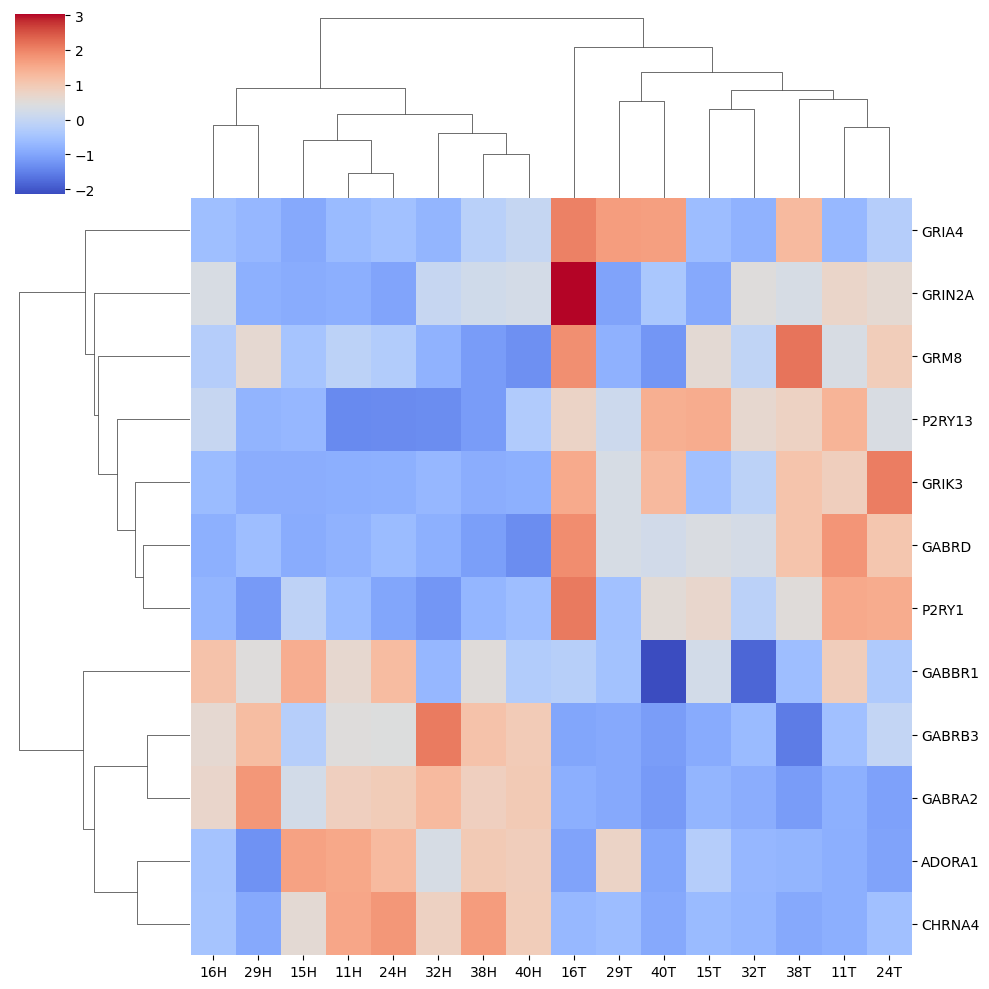

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the matrix
matrix = [
    [-0.787744, 1.785030, -0.888294, 0.373481, -0.837633, 1.887628, -0.623350, 1.064972, -0.596530, 0.306860, -0.841068, 0.281668, -1.094671, 1.098374, -1.338505, 0.209782],
    [-0.852057, 0.879645, -0.865465, -0.546201, -0.636235, 1.511181, -0.837142, 2.080372, -0.875088, 0.308497, -0.715547, -0.135007, -0.870634, 1.111631, -0.840349, 1.282398],
    [1.548166, -0.849948, 1.629101, -0.245342, -0.496544, -1.040681, 1.274390, -1.043692, -1.281491, 0.752835, 0.323166, -0.708393, 0.977527, -0.751540, 0.900741, -0.988295],
    [-0.660558, -0.693151, -0.936473, -0.613473, -0.565155, 2.033660, -0.527424, -0.248133, -0.704536, 1.697312, -0.760922, -0.789651, -0.187261, 1.269460, 0.010460, 1.675846],
    [0.471592, -0.552210, -0.228182, -0.908167, 0.614208, -0.987818, 0.445083, -0.033518, 1.232966, -0.926231, 2.101277, -0.648820, 1.124857, -1.554649, 0.958148, -1.108534],
    [-0.848707, 0.728027, -0.893071, -0.932752, 0.334073, 3.030701, -1.020564, 0.599604, -0.839266, -1.037567, 0.026593, 0.483713, 0.201525, 0.315823, 0.255569, -0.403702],
    [1.558817, -0.845413, 0.575641, -0.651266, -0.463460, -0.697474, 1.759541, -0.546409, -0.925589, -0.613705, 0.828406, -0.729409, 1.715231, -0.939744, 0.916649, -0.941815],
    [-1.376757, 1.367640, -0.720501, 1.481815, 0.043820, 0.766062, -1.367519, 0.354327, -0.781687, 0.136017, -1.342287, 0.639633, -1.131919, 0.804635, -0.311554, 1.438275],
    [-0.639592, 1.535069, -0.109740, 0.677917, -0.750801, 2.120697, -0.985775, 1.493702, -1.147063, -0.532710, -1.212943, -0.149148, -0.724219, 0.492247, -0.598098, 0.530458],
    [0.861400, -0.843392, 0.235666, -0.759004, 0.703441, -0.845396, 0.943600, -1.053139, 1.761275, -0.942178, 1.265175, -0.879387, 0.867809, -1.145831, 0.978417, -1.148454],
    [0.641501, 0.908391, 1.474636, 0.243068, 1.123706, -0.217002, 1.242359, -0.324273, 0.472465, -0.506550, -0.719984, -1.829888, 0.494483, -0.583348, -0.284414, -2.135151],
    [-0.131849, 0.326975, -0.477787, 0.578395, -0.249734, 1.871719, -0.292181, 0.914728, 0.618674, -0.822692, -0.791219, -0.073585, -1.130134, 2.168880, -1.288961, -1.221229]
]

# Define the row and column labels
rows = [
    'GABRD', 'GRIK3', 'ADORA1', 'GRIA4', 'GABRB3', 'GRIN2A', 'CHRNA4', 'P2RY13', 'P2RY1', 'GABRA2', 'GABBR1', 'GRM8'
]
columns = [
    '11H', '11T', '15H', '15T', '16H', '16T', '24H', '24T', '29H', '29T', '32H', '32T', '38H', '38T', '40H', '40T'
]

# Create the heatmap using seaborn
sns.clustermap(matrix, cmap='coolwarm', row_cluster=True, col_cluster=True,
               xticklabels=columns, yticklabels=rows)

# Display the heatmap
plt.show()


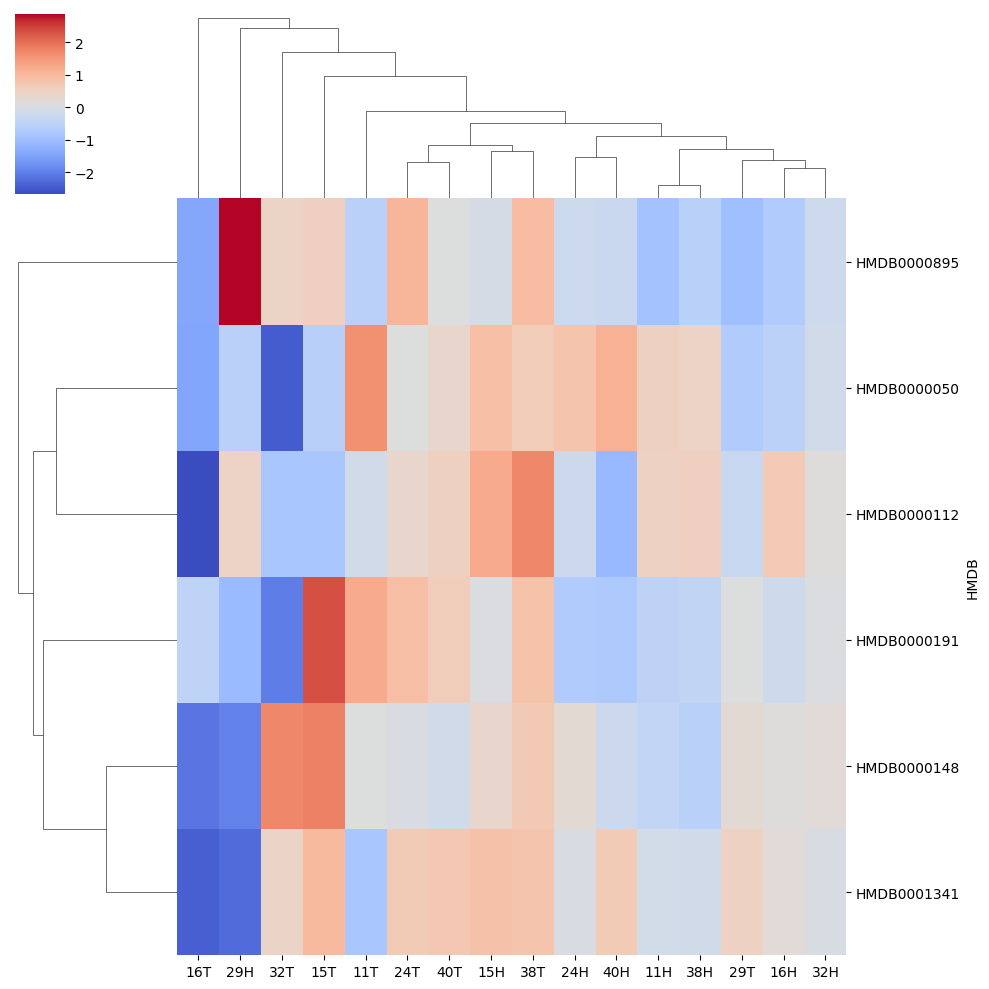

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


rows = hm2.index
columns = hm2.columns

# Create the heatmap using seaborn
sns.clustermap(hm2, cmap='coolwarm', row_cluster=True, col_cluster=True,
               xticklabels=columns, yticklabels=rows)

# Display the heatmap
plt.show()


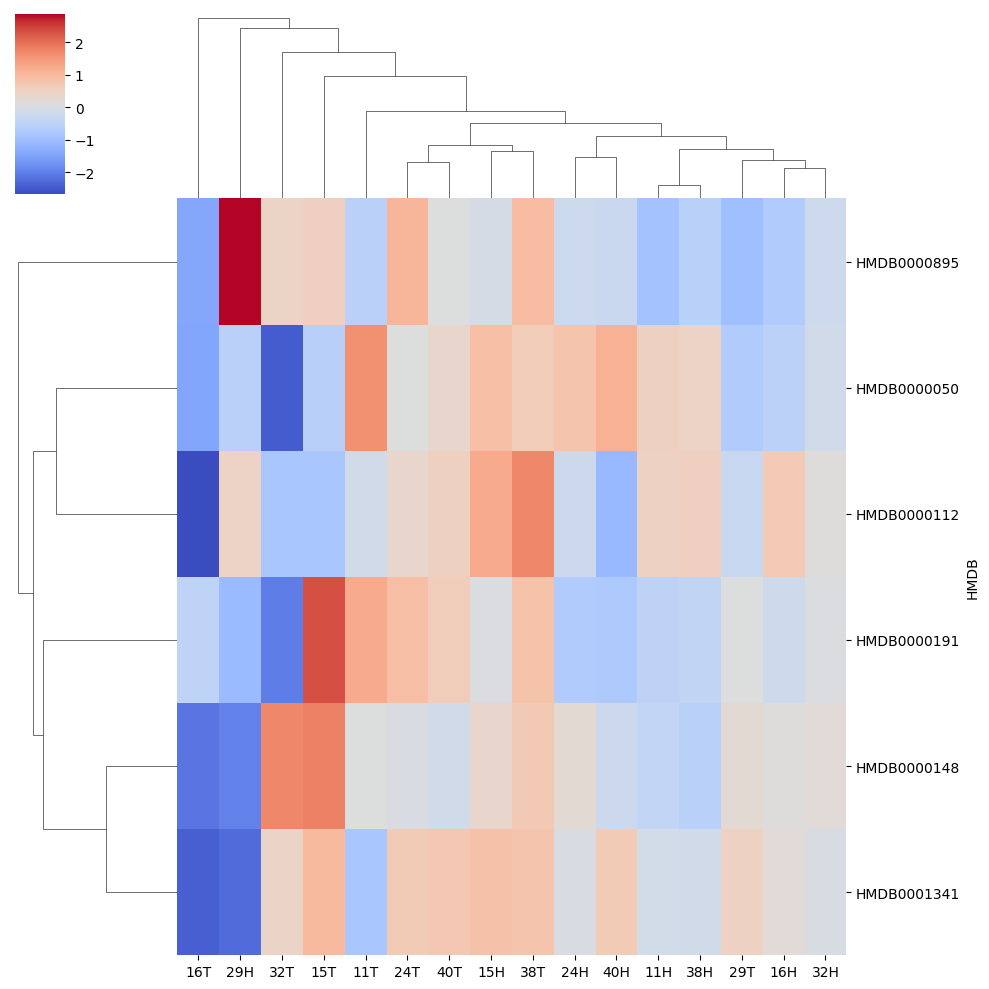

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


rows = hm2.index
columns = hm2.columns

# Create the heatmap using seaborn
sns.clustermap(hm2, cmap='coolwarm', row_cluster=True, col_cluster=True,
               xticklabels=columns, yticklabels=rows)

# Display the heatmap
plt.show()
